**author**: JZ

**project**: ADAPT

**topic**: Desiree pilot study

**date**: 2023-1-27

# study design
- per each day after stress = DAS, 29
- 6 treatments
- 6 replicate plants
- size is 29x36=1044

# goal
- Feature Selection (FS) - which measured features as a reponse to stress, are most indiciative of the stress



# Notes

**approaches:**

- A. drop rows with nans + select DAS = 4,11,18 -> size 82 x 21, split 80/20%
- B. drop cols with nans + select DAS <=14 -> size 450 x 14, split 80/20%


**drop**:

- day 0 
- day > 14 - stress conditions
- day 1 waterlogging
- HDW - as most plants dead

**adjust**:
- tretment marks to align with real conditions
    - HD where day < 8 is H
    - D where day < 8 is C
    - HDW where day < 8 is H
    - HDW where 8<= day >= 14 is HD


**Considerations**
- improvements: imputation
- inspect waterlogging days 8-14
- choose insensitive method to class imbalance
- permutation FS can rise many similar values, add relieff, cfs if implemented
- forward/backward FS algoritms most meaningful

**Phenodata**
- Master sample description file
- ../../../01_Experimental-design-and-days-of-tissue-sampling.xlsx



# packages and modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import shap
import session_info
import xgboost

# set seeds
seed = 6666
np.random.seed(seed)

# data

In [2]:
df = (pd.read_excel('../input/PhenoDataSUM_PILOT2020_NIB.xlsx', skiprows=1) # updated file
      .rename(columns={'Day after Stress Induction/DAS': 'DAS'})
)
print(df.shape)
print(29*6*6)
df.head(20)

(1044, 25)
1044


,DAS,Plant ID,Replica,Treatment,SIDE-AREA,WIDTH,HEIGHT,TOP-AREA,COMPACTNESS,ROUNDNESS,...,qP,qL,ΔT,PRI,NDVI,SIPI,MCARI,OSAVI,WATER1,WATER CONSUMPTION
0,0,C_P35__1,1,Control,NaN,NaN,NaN,NaN,NaN,NaN,...,0.931136,1.094806,0.487356,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,C_P35__2,2,Control,NaN,NaN,NaN,NaN,NaN,NaN,...,0.935363,1.086704,0.254845,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,C_P35__3,3,Control,22538.523921,283.511605,333.649948,85530.154067,0.676404,0.099217,...,0.956595,1.059119,0.317326,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,C_P35__4,4,Control,23738.560777,297.741917,329.152560,66378.413988,0.693832,0.103960,...,0.953339,1.056840,0.312260,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,C_P35__5,5,Control,22706.444980,327.570840,324.092999,76753.878661,0.688258,0.073080,...,0.959459,1.049582,-0.028524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,C_P35__6,6,Control,25811.561497,306.499032,347.704284,97157.198987,0.665279,0.108559,...,0.950779,1.064650,0.154772,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,D_P35__1,1,Drought,NaN,NaN,NaN,NaN,NaN,NaN,...,0.926053,1.098277,0.314394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,D_P35__2,2,Drought,NaN,NaN,NaN,NaN,NaN,NaN,...,0.948807,1.069726,0.262518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,D_P35__3,3,Drought,21605.253089,354.115846,367.942529,87474.499451,0.711694,0.112292,...,0.969463,1.041064,0.522541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,D_P35__4,4,Drought,18953.387533,250.946082,347.142111,69650.868965,0.660002,0.117701,...,0.933555,1.086655,0.473764,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
[print(df[c].unique()) for c in df[['DAS', 'Plant ID', 'Replica', 'Treatment']].columns]
[print(df[c].unique().shape) for c in df[['DAS', 'Plant ID', 'Replica', 'Treatment']].columns]
[print(df[c].value_counts()) for c in df[['DAS', 'Plant ID', 'Replica', 'Treatment']].columns]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
['C_P35__1' 'C_P35__2' 'C_P35__3' 'C_P35__4' 'C_P35__5' 'C_P35__6'
 'D_P35__1' 'D_P35__2' 'D_P35__3' 'D_P35__4' 'D_P35__5' 'D_P35__6'
 'H_P35__1' 'H_P35__2' 'H_P35__3' 'H_P35__4' 'H_P35__5' 'H_P35__6'
 'HD_P35__1' 'HD_P35__2' 'HD_P35__3' 'HD_P35__4' 'HD_P35__5' 'HD_P35__6'
 'HDW_P35__1' 'HDW_P35__2' 'HDW_P35__3' 'HDW_P35__4' 'HDW_P35__5'
 'HDW_P35__6' 'W_P35__1' 'W_P35__2' 'W_P35__3' 'W_P35__4' 'W_P35__5'
 'W_P35__6']
[1 2 3 4 5 6]
['Control' 'Drought' 'Heat' 'Heat + Drought'
 'Heat + Drought + Waterlogging' 'Waterlogging']
(29,)
(36,)
(6,)
(6,)
DAS
0     36
15    36
27    36
26    36
25    36
24    36
23    36
22    36
21    36
20    36
19    36
18    36
17    36
16    36
14    36
1     36
13    36
12    36
11    36
10    36
9     36
8     36
7     36
6     36
5     36
4     36
3     36
2     36
28    36
Name: count, dtype: int64
Plant ID
C_P35__1      29
C_P35__2      29
HD_P35__3     29
HD_P35_

[None, None, None, None]

# conditions

In [4]:
# fix treatments
df['DAS'] = df.DAS.astype(int) # assert
print(df.shape)
df = df.query('DAS>0') #.query('Treatment!="Heat + Drought + Waterlogging"') # dead
print(df.shape)

# control=ok
# drought
df.loc[(df.Treatment=='Drought')&(df.DAS<8),'Treatment'] = 'Control'
df.loc[(df.Treatment=='Drought')&(df.DAS>14),'Treatment'] = 'Control'
# heat
df.loc[(df.Treatment=='Heat')&(df.DAS>14),'Treatment'] = 'Control'
# heat+drought
df.loc[(df.Treatment=='Heat + Drought')&(df.DAS<8),'Treatment'] = 'Heat'
df.loc[(df.Treatment=='Heat + Drought')&(df.DAS>14),'Treatment'] = 'Control'
# waterlogging
df.loc[(df.Treatment=='Waterlogging')&(df.DAS>14),'Treatment'] = 'Control'
# HDW
df.loc[(df.Treatment=="Heat + Drought + Waterlogging")&(df.DAS<8),'Treatment'] = 'Heat' #query('Treatment!="Heat + Drought + Waterlogging"') # dead
df.loc[(df.Treatment=="Heat + Drought + Waterlogging")&(df.DAS>8),'Treatment'] = 'Heat + Drought'

# check imbalance pre-subselection
print(df.Treatment.value_counts())


(1044, 25)
(1008, 25)
Treatment
Control                          546
Heat                             168
Heat + Drought                   162
Waterlogging                      84
Drought                           42
Heat + Drought + Waterlogging      6
Name: count, dtype: int64


# Test classification performance
Define experiments:
1. drop NAs on last columns to have full valued dataset, classification on all treatments but DHW where most plants were dead
2. similarly classification but removing or including the mostly nan last columns vars

https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0

## 80/20% split

In [ ]:
np.random.seed(seed)

df['DAS'] = df.DAS.astype(int)
df1 = (df
      .drop(columns=['PRI', 'NDVI',
      'SIPI', 'MCARI', 'OSAVI', 'WATER1']) # dont remove 'WATER CONSUMPTION'
      .dropna()
      #.dropna(subset=['WATER1'])
      .query('Treatment!="Heat + Drought + Waterlogging"') # dead
      .query('DAS<=14') # approx first two weeks
      )
print(df1.shape)
df1 = df1[~((df1.Treatment=='Waterlogging')&(df1.DAS>8))] # remove waterlogging after dat 7
print(df1.shape)
df1 = df1[~((df1.Treatment=='WATER CONSUMPTION')&(df1.DAS<2))] # remove before day 2

print(df1.shape)
print(df1.dropna(how='any').shape) # sanity
df1.groupby(['Plant ID']).Treatment.value_counts()
X = df1.drop(columns=['DAS','Plant ID','Replica','Treatment']).values
xnames = list(df1.drop(columns=['DAS','Plant ID','Replica','Treatment']).columns)
print(X.shape)

# check imbalance
print(df1.Treatment.value_counts())

# encode treatment
keys = df1.Treatment.unique()
values = list(range(df1.Treatment.unique().shape[0]))
dic = dict(zip(keys, values))
print(dic)
y = df1.Treatment.replace(dic)
print(y.shape)

# scale x
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=8675309)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(459, 19)
(423, 19)
(423, 19)
(423, 19)
(423, 15)
Treatment
Heat              149
Control           112
Heat + Drought     78
Waterlogging       42
Drought            42
Name: count, dtype: int64
{'Control': 0, 'Heat': 1, 'Waterlogging': 2, 'Drought': 3, 'Heat + Drought': 4}
(423,)
(338, 15)
(85, 15)
(338,)


## define models

In [ ]:
np.random.seed(seed)

# https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
        ('LogReg', LogisticRegression()), 
        ('RF', RandomForestClassifier()),
        ('KNN', KNeighborsClassifier()),
        ('SVM', SVC()), 
        ('GNB', GaussianNB()),
        ('XGB', XGBClassifier())
        ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'] # 'roc_auc' multicalss not supprted
    target_names = dic.keys()
    print(target_names)
    models_trained = []
    for name, model in models:
        print(name,model)
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
    
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        models_trained.append(clf)
        
    final = pd.concat(dfs, ignore_index=True)
    return final, models_trained

final, models_trained = run_exps(X_train, y_train, X_test, y_test)

dict_keys(['Control', 'Heat', 'Waterlogging', 'Drought', 'Heat + Drought'])
LogReg LogisticRegression()
LogReg
                precision    recall  f1-score   support

       Control       0.96      1.00      0.98        25
          Heat       0.96      1.00      0.98        25
  Waterlogging       1.00      1.00      1.00        11
       Drought       1.00      0.80      0.89         5
Heat + Drought       1.00      0.95      0.97        19

      accuracy                           0.98        85
     macro avg       0.98      0.95      0.96        85
  weighted avg       0.98      0.98      0.98        85

RF RandomForestClassifier()
RF
                precision    recall  f1-score   support

       Control       1.00      1.00      1.00        25
          Heat       0.89      1.00      0.94        25
  Waterlogging       1.00      1.00      1.00        11
       Drought       1.00      1.00      1.00         5
Heat + Drought       1.00      0.84      0.91        19

      accurac

### bootstrap

In [ ]:
np.random.seed(seed)

bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')


## model evaluation plot

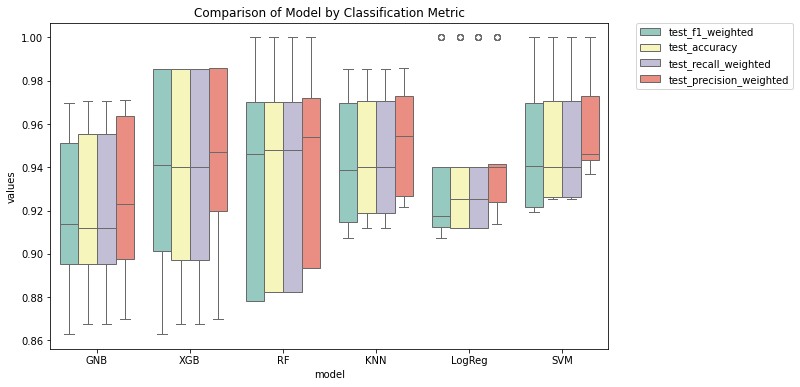

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
#sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
# plt.savefig('./benchmark_models_performance-drop_cols-'+str(seed)+'.png',dpi=300,bbox_inches='tight')
plt.savefig('../reports/model comparison.svg', dpi = 300, bbox_inches='tight')

# Feature selection
methods: 
- anova
- mutual information
- random forest model 3 methods 
    - feature importance
    - permutation importance
    - shap vales

refs:
- https://machinelearningmastery.com/feature-selection-with-numerical-input-data/
- https://mljar.com/blog/feature-importance-in-random-forest/
- https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

In [9]:
# feature selection for numeric input and categorical output
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

## anova

In [10]:

# anova
# # generate dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=2)
print(X_scaled.shape,y.shape)

# define feature selection
fs = SelectKBest(score_func=f_classif, k='all')

# apply feature selection
X_selected = fs.fit_transform(X_scaled, y)
print(X_selected.shape)

# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]) +' : '+ xnames[i])
# plot the scores
# plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
# plt.show()

(423, 15) (423,)
(423, 15)
Feature 0: 52.304672 : SIDE-AREA
Feature 1: 127.312259 : WIDTH
Feature 2: 87.446861 : HEIGHT
Feature 3: 212.600809 : TOP-AREA
Feature 4: 359.512487 : COMPACTNESS
Feature 5: 205.241528 : ROUNDNESS
Feature 6: 173.576621 : ISOTROPY
Feature 7: 197.356377 : SOL
Feature 8: 95.529453 : VOLUME_MM^3
Feature 9: 166.238481 : Fv´/Fm´
Feature 10: 132.097600 : ɸPSII
Feature 11: 51.112178 : qP
Feature 12: 168.822869 : qL
Feature 13: 243.502113 : ΔT
Feature 14: 227.908796 : WATER CONSUMPTION


In [11]:
def normalize(xx):
    return [(x-xx.min())/(xx.max()-xx.min()) for x in xx]
df_res = pd.DataFrame(xnames,columns=['feature'])
df_res['anova_score'] = normalize(fs.scores_)

## mutual information

In [12]:
# mutual info
# configure to select all features
fs = SelectKBest(score_func=mutual_info_classif, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)

# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]) +' : '+ xnames[i])
# plot the scores
# plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
# plt.show()

df_res['mutinfo_score'] = normalize(fs.scores_)

Feature 0: 0.376466 : SIDE-AREA
Feature 1: 0.429946 : WIDTH
Feature 2: 0.407240 : HEIGHT
Feature 3: 0.664503 : TOP-AREA
Feature 4: 0.599066 : COMPACTNESS
Feature 5: 0.655688 : ROUNDNESS
Feature 6: 0.464324 : ISOTROPY
Feature 7: 0.507884 : SOL
Feature 8: 0.507252 : VOLUME_MM^3
Feature 9: 0.585836 : Fv´/Fm´
Feature 10: 0.460670 : ɸPSII
Feature 11: 0.472640 : qP
Feature 12: 0.709337 : qL
Feature 13: 0.624634 : ΔT
Feature 14: 0.917899 : WATER CONSUMPTION


 ## random forest

In [13]:
# get feature importances from rf model
#models_trained[1].feature_importances_
rf = models_trained[1]
df_res['rf_importance'] = normalize(rf.feature_importances_)

from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(rf, X_test, y_test)
df_res['rf_perm'] = normalize(perm_importance.importances_mean)

explainer = shap.TreeExplainer(rf)
#shap_values = explainer.shap_values(X_test)
#np.array(shap_values).mean(axis=1).mean(axis=0) # probably not correct way
#df_res['rf_shap'] = normalize(shap_values) # no go

#https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
from scipy.special import softmax
shap_values = explainer(X_test)
# Calculates the feature importance (mean absolute shap value) for each feature
importances = []
for i in range(shap_values.values.shape[1]):
    importances.append(np.mean(np.abs(shap_values.values[:, i])))
# Calculates the normalized version
#importances_norm = softmax(importances) # strange all equal vals
df_res['rf_shap'] = normalize(np.array(importances))

#df_res


## shap plot

In [14]:
# shap: 
#shap_values = explainer.shap_values(X_test)
#shap.summary_plot(shap_values, X_test) #plot_type="bar"
#plt.show()

# # The feature importance can be plotted with more details, showing the feature value:
# shap.summary_plot(shap_values, X_test)
# shap.plots.beeswarm(shap_values)
# plt.show()

# see here for more plots 
# https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

## feature importance plot

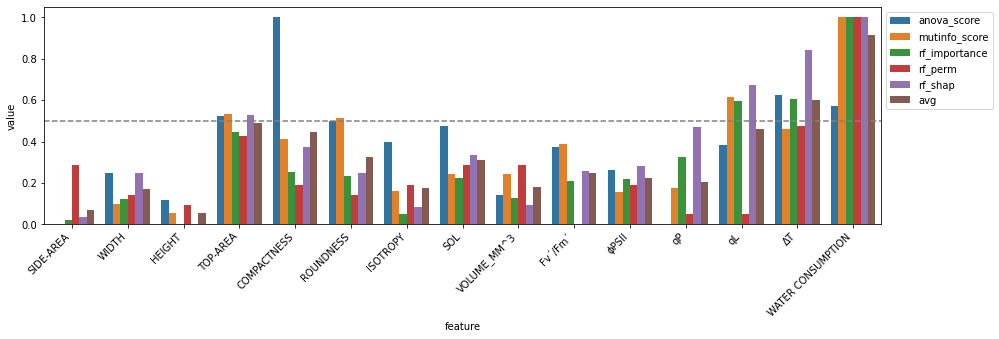

In [ ]:
# plot
df_res['avg'] = df_res.iloc[:,1:].mean(axis=1) # add avgs
plt.figure(figsize=(15,4))
sns.barplot(data=df_res.melt(id_vars=['feature'],value_vars=['anova_score',
                                                            'mutinfo_score',
                                                            'rf_importance',
                                                            'rf_perm',
                                                            'rf_shap',
                                                            'avg'
                                                            ]),
            x='feature',y='value',hue='variable')
plt.xticks(rotation=45,ha='right')
plt.legend(bbox_to_anchor=(1,1))
plt.axhline(y=0.5, color='grey', linestyle='--')
# plt.savefig('feature_scores-drop_cols-'+str(seed)+'.png',dpi=300,bbox_inches='tight')
plt.savefig('../reports/feature_importance_all.svg',dpi=300,bbox_inches='tight')
plt.show()

C:\Users\majaz\AppData\Local\Temp\ipykernel_17768\2042843981.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1,1))


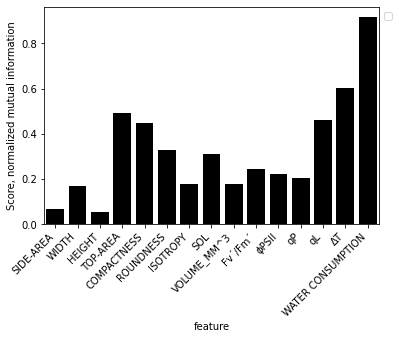

In [ ]:

# plot
df_res['avg'] = df_res.iloc[:,1:].mean(axis=1) # add avgs
plt.figure(figsize=(6,4))
sns.barplot(data=df_res,
            x='feature',y='avg',
            color='k'
        ) #y='value',hue='variable')
plt.xticks(rotation=45,ha='right')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Score, normalized mutual information')
plt.savefig('../reports/avg-drop_cols.svg',dpi=300,bbox_inches='tight')
plt.show()

In [17]:
df_res.sort_values(by='avg',ascending=False).to_csv('../output/feature_scores-drop_cols-'+str(seed)+'.csv', index=False)
df_res.sort_values(by='avg',ascending=False)

,feature,anova_score,mutinfo_score,rf_importance,rf_perm,rf_shap,avg
14,WATER CONSUMPTION,0.573270,1.000000,1.000000,1.000000,1.000000,0.914654
13,ΔT,0.623832,0.458355,0.606148,0.476190,0.842740,0.601453
3,TOP-AREA,0.523633,0.531991,0.444265,0.428571,0.526126,0.490917
12,qL,0.381681,0.614796,0.595694,0.047619,0.674450,0.462848
4,COMPACTNESS,1.000000,0.411131,0.254250,0.190476,0.372703,0.445712
5,ROUNDNESS,0.499770,0.515708,0.231455,0.142857,0.248340,0.327626
7,SOL,0.474203,0.242723,0.221904,0.285714,0.336437,0.312196
9,Fv´/Fm´,0.373302,0.386696,0.211744,0.000000,0.258302,0.246009
10,ɸPSII,0.262598,0.155521,0.218570,0.190476,0.280533,0.221540
11,qP,0.000000,0.177629,0.326991,0.047619,0.469598,0.204367


# session

In [18]:
session_info.show()